In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(SeuratDisk)
    library(scCustomize) 
    library(SCP)
    library(ggplot2)
    library(dplyr)
    library(knitr)
    library(readr) 
    library(ggsci)
    library(scater)
    library(DoubletFinder)
    library(Trex)    
    library(SCpubr)
    library(biomaRt)
    library(data.table)
    library(genekitr)
    library(Azimuth)
    library(UCell)
    library(harmony)

    load("data/cycle.rda")
    source('helper_functions.R')
    
})


options(future.globals.maxSize = 128*1024**3)
plan(strategy = "multicore", workers = 1)
plan()

set.seed(123)

multicore:
- args: function (..., workers = 1, envir = parent.frame())
- tweaked: TRUE
- call: plan(strategy = "multicore", workers = 1)
FutureBackend to be launched

In [2]:
prepost <- readRDS("../ProcessedData/seurat/filtered_ip4.rds")

##### Srublet Doublets

In [ ]:
scrublet = read.csv('results/scrublet_doublets_IP.csv')
rownames(scrublet) <- scrublet$X
scrublet <- scrublet[c('doublet_score', 'predicted_doublet')]
prepost <- AddMetaData(prepost, scrublet)

In [37]:
prepost$doublet_threshold = (prepost$doublet_score > 0.2)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=170)
FeatureStatPlot(prepost, group.by = "doublet_threshold", stat.by = c("nCount_RNA", "nFeature_RNA"),
                plot_type='box', legend.position='none')

#### dimred

In [34]:
prepost <- subset(prepost, doublet_score < 0.2)

In [75]:
prepost <- preprocess_seurat_object(prepost,  g2m_genes, s_genes, nfeatures = 1000, phase_threshold = 5)

Centering and scaling data matrix

PC_ 1 
Positive:  HOPX, NKG7, LGALS1, GZMB, CCL5, CTSW, PRF1, FUT7, LINC02694, LAG3 
	   CD8A, LGALS3, CXCR3, CD8B, LINC01871, ZNF683, ATP8B4, HPGD, KLRK1, TNFRSF1B 
	   GNLY, SETBP1, CTSH, F2R, TNFRSF18, LINC02446, LINC01943, DEC1, OSM, FXYD2 
Negative:  STAT1, FHIT, TCF7, SESN3, IL7R, CCR7, AC139720.1, FOS, GBP1, RGS1 
	   ANK3, FAM13A, TNFSF13B, GBP5, INPP4B, TSHZ2, DUSP2, GBP4, XIST, IL12RB2 
	   PTGIR, PDE7B, PLCL1, IGFBP4, TTN, CALHM6, TAFA1, AC090125.1, LINC00271, CLDN5 
PC_ 2 
Positive:  CD8A, CD8B, CTSW, LINC02446, PECAM1, KLRK1, FXYD2, AIF1, ZNF683, TIMD4 
	   NKG7, AOAH, CAPG, NELL2, BACH2, C20orf204, GZMB, PRF1, CCL5, KLRC4 
	   CCR7, FCER1G, CD9, PTMS, GBP5, FGFBP2, LAG3, KLRC1, AC105402.3, PTGIS 
Negative:  MAF, ITGB1, CD40LG, CD59, TNFRSF4, LINC02694, TNFRSF1B, TNFRSF18, RNF213, CCR6 
	   PTPN13, SOS1, TBXAS1, FRY, LINC01943, RORC, AL136456.1, TSHZ2, CTSH, LGALS3 
	   LINC00892, CYTOR, LMNA, GREM2, S100P, IL17RB, KLRB1, ZEB2, GPR15, CFH

In [77]:
prepost <- RunHarmony(prepost, 'Batch', verbose = FALSE)

In [78]:
prepost <- FindNeighbors(prepost, reduction = "harmony", dims = 1:50)
prepost <- FindClusters(prepost, resolution = .5, cluster.name = "harmony_clusters", algorithm = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37719
Number of edges: 1226744

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8442
Number of communities: 12
Elapsed time: 7 seconds


In [79]:
summary_stats <- prepost@meta.data %>%
  group_by(harmony_clusters) %>%
  summarize(
    num_cells = n(),
    median_nUMI = median(nCount_RNA),
    median_nGene = median(nFeature_RNA),
    median_percent_mt = round(median(percent.mt),2),
    median_percent_ribo = round(median(percent.ribo),2)
  )
kable((summary_stats), format = "markdown")



|harmony_clusters | num_cells| median_nUMI| median_nGene| median_percent_mt| median_percent_ribo|
|:----------------|---------:|-----------:|------------:|-----------------:|-------------------:|
|0                |      9192|     10656.0|       3453.0|              3.88|               21.05|
|1                |      8785|     14896.0|       4161.0|              4.15|               18.50|
|2                |      7713|     12336.0|       3611.0|              3.95|               18.99|
|3                |      4878|      5646.0|       2042.0|              3.80|               27.91|
|4                |      2717|     12540.0|       3733.0|              3.93|               22.16|
|5                |      1249|     13480.0|       3826.0|              3.94|               21.34|
|6                |       894|      4713.0|       2210.5|              6.75|                6.35|
|7                |       716|      8489.5|       2912.5|              3.94|               21.11|
|8                

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=170)
FeatureStatPlot(prepost, group.by = "harmony_clusters", stat.by = c("percent.ribo", "percent.mt"),
                plot_type='box', legend.position='none')

In [80]:
# removing low quality clusters  
prepost <- subset(prepost, harmony_clusters %!in% c(6))

In [ ]:
prepost <- preprocess_seurat_object(prepost,  g2m_genes, s_genes, nfeatures = 1000, phase_threshold = 5)
prepost <- RunHarmony(prepost, 'Batch', verbose = FALSE)

In [ ]:
prepost <- FindNeighbors(prepost, reduction = "harmony", dims = 1:50)
prepost <- FindClusters(prepost, resolution = .6, cluster.name = "harmony_clusters", algorithm = 1)

In [ ]:
prepost <- RunUMAP(prepost, reduction = "harmony", dims = 1:50, verbose=F, reduction.name = "umap.harmony", 
                   spread=1, min.dist=.3, n.neighbors = 30, metric='cosine')

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 6, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "harmony_clusters"), 
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


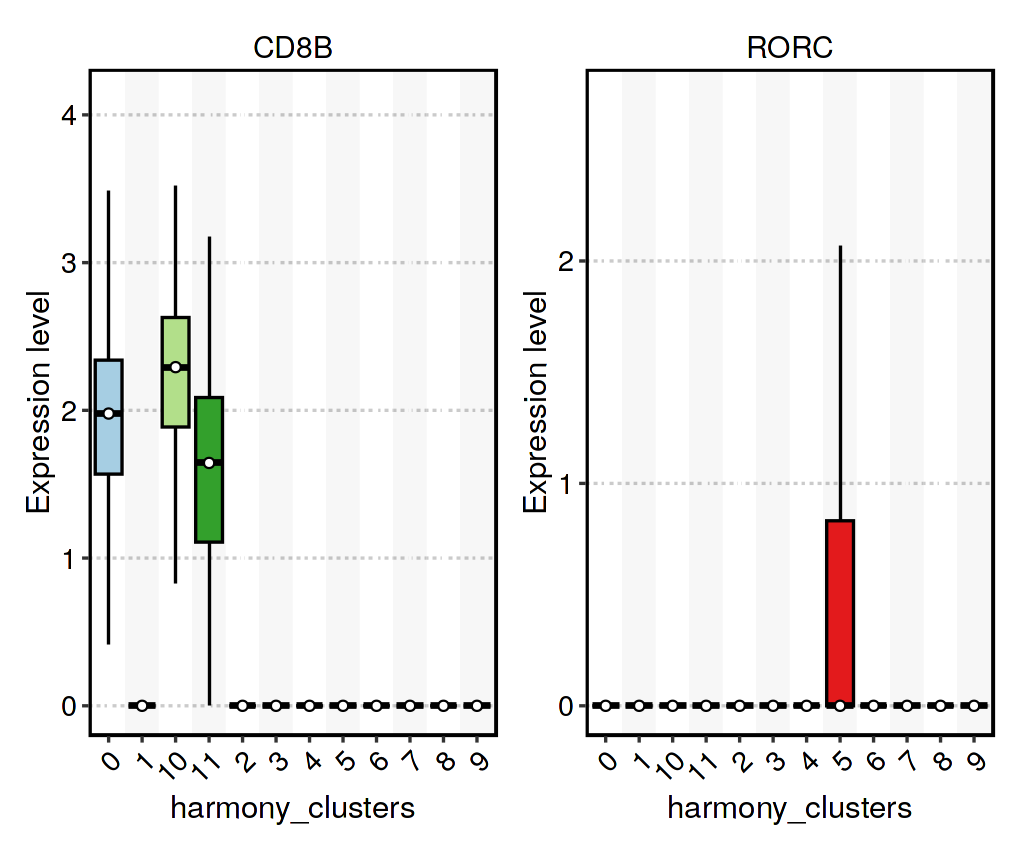

In [97]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=170)
FeatureStatPlot(prepost, group.by = "harmony_clusters", stat.by = c("CD8B", "RORC"),
                plot_type='box', legend.position='none')

In [ ]:
NKG7, GZMB, CCL5, PRF1, GNLY
MAF, ITGB1, CD40LG, CD59, TNFRSF4,
CD8A, CD8B, CTSW, KLRK1, 
HLA-DRB5, HLA-DQA1, HLA-DPA1, HLA-DPB1, HLA-DQA2, CD74

TNFRSF18

In [ ]:
PTGDR2 (CRTH2/CD294) shows very high expression, which is the canonical surface marker for human Th2 cells
GATA3 has high expression and is the master transcription factor for Th2 differentiation
GATA3-AS1, an antisense RNA associated with GATA3, supports Th2 identity
IL17RB (IL-25 receptor) shows strong expression, which is characteristic of Th2 cells
IL9R expression is consistent with Th2 functionality
MAF transcription factor is expressed, which cooperates with GATA3 in Th2 cells
IRX3 shows expression pattern typical of Th2 cells

In [117]:
genes <- c(
    'CAR', "CD40LG","CD4","MAL", "CD8B","CD8A","GZMH", "MKI67",'TOP2A','NUSAP1',
    'RORC','CCR6','KLRB1','IL26',
    'PTGDR2', "IRX3","IL9R","IL17RB",
    "FOXP3", "IKZF2","IL2RA", 
    'CCR7','TCF7','SELL','NELL2','GZMK','PRF1','CCR4','HAVCR2'
) 

# 'MRC1','EMP3' - BAM
# 'MT1G','MT1H','CCL7' - MT-MAC
#  'SPP1','C1QA','C1QB', 

In [118]:
5 - TH17
6 - TH2
7 - Treg

ERROR: Error: object 'TH17' not found


In [108]:
th17_markers <- c("RORC", "STAT3", "IL17A", "IL17F", "IL22", "IL23R", "CCR6", "KLRB1", "IL1R1", "IL6R", "BATF", "AHR", "IL21", "IL26", "CCL20", "IL21R", "SOCS3", "IRF4", "RORA", "SGK1", "IKZF3", "PLZF")
th2_markers <- c("GATA3", "STAT6", "IL4", "IL5", "IL13", "IL4R", "PTGDR2", "CCR4", "CCR8", "IL9R", "IL17RB", "MAF", "GFI1", "PARP14", "IRF4", "GATA3AS1", "SOCS1", "CISH", "DUSP4", "IRX3", "IL10", "IL33R")
tfh_markers <- c("BCL6", "CXCR5", "PDCD1", "ICOS", "CD40LG", "IL21", "BTLA", "SH2D1A", "ASCL2", "MAF", "TOX", "TOX2", "TIGIT", "SLAMF1", "CXCL13", "IL6ST", "IL4", "IL10", "CCR7", "BHLHE40", "PRDM1", "TRAF3")

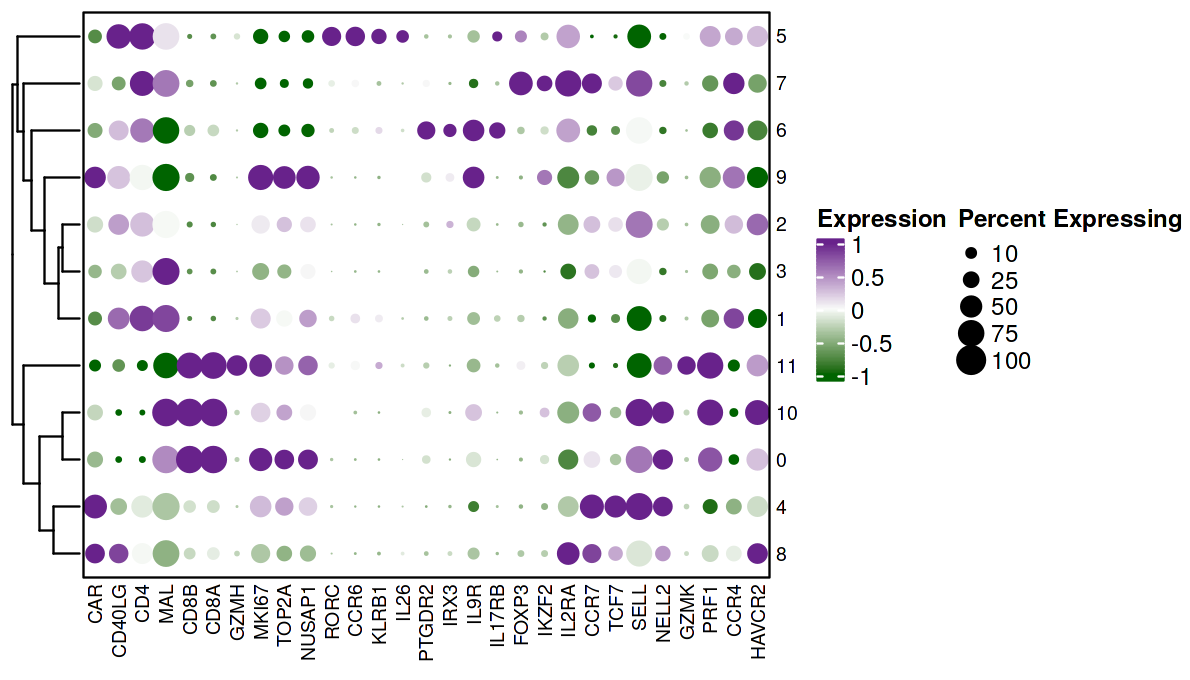

In [139]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res=170)
P <- Clustered_DotPlot(prepost,  features = genes, k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = T, flip=T, exp_color_max=1, exp_color_min=-1,  
        show_ident_colors=F,  colors_use_exp = colorRampPalette(c("darkgreen","white","darkorchid4"))(50)) 

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."
Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's colour values."


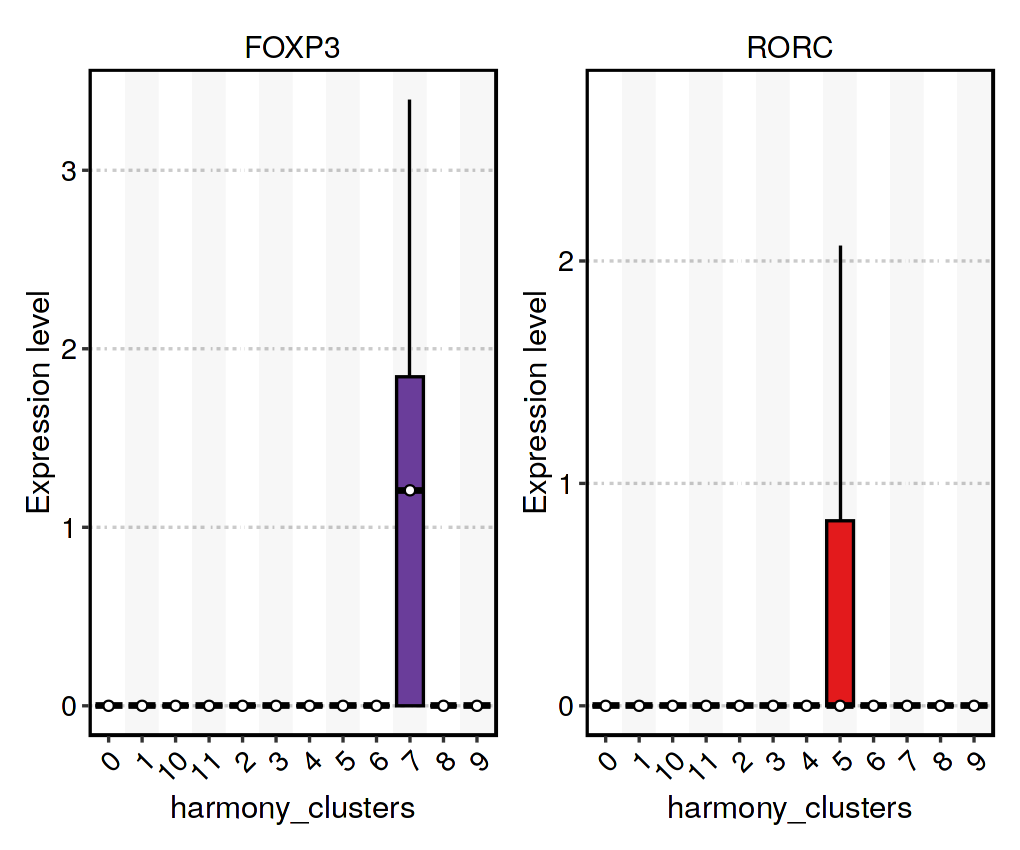

In [100]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=170)
FeatureStatPlot(prepost, group.by = "harmony_clusters", stat.by = c("FOXP3", "RORC"),
                plot_type='box', legend.position='none')

In [ ]:
Idents(prepost) <- 'harmony_clusters'
de.markers <- FindMarkers(prepost, ident.1 = '8', only.pos = TRUE)
de.markers$diff =  de.markers$pct.1 -  de.markers$pct.2
# head(de.markers %>% arrange(-avg_log2FC), 50)
head(de.markers %>% arrange(-diff), 50)

In [ ]:
NKG7, GZMB, CCL5, PRF1, GNLY
MAF, ITGB1, CD40LG, CD59, TNFRSF4,
CD8A, CD8B, CTSW, KLRK1, 
HLA-DRB5, HLA-DQA1, HLA-DPA1, HLA-DPB1, HLA-DQA2, CD74

TNFRSF18

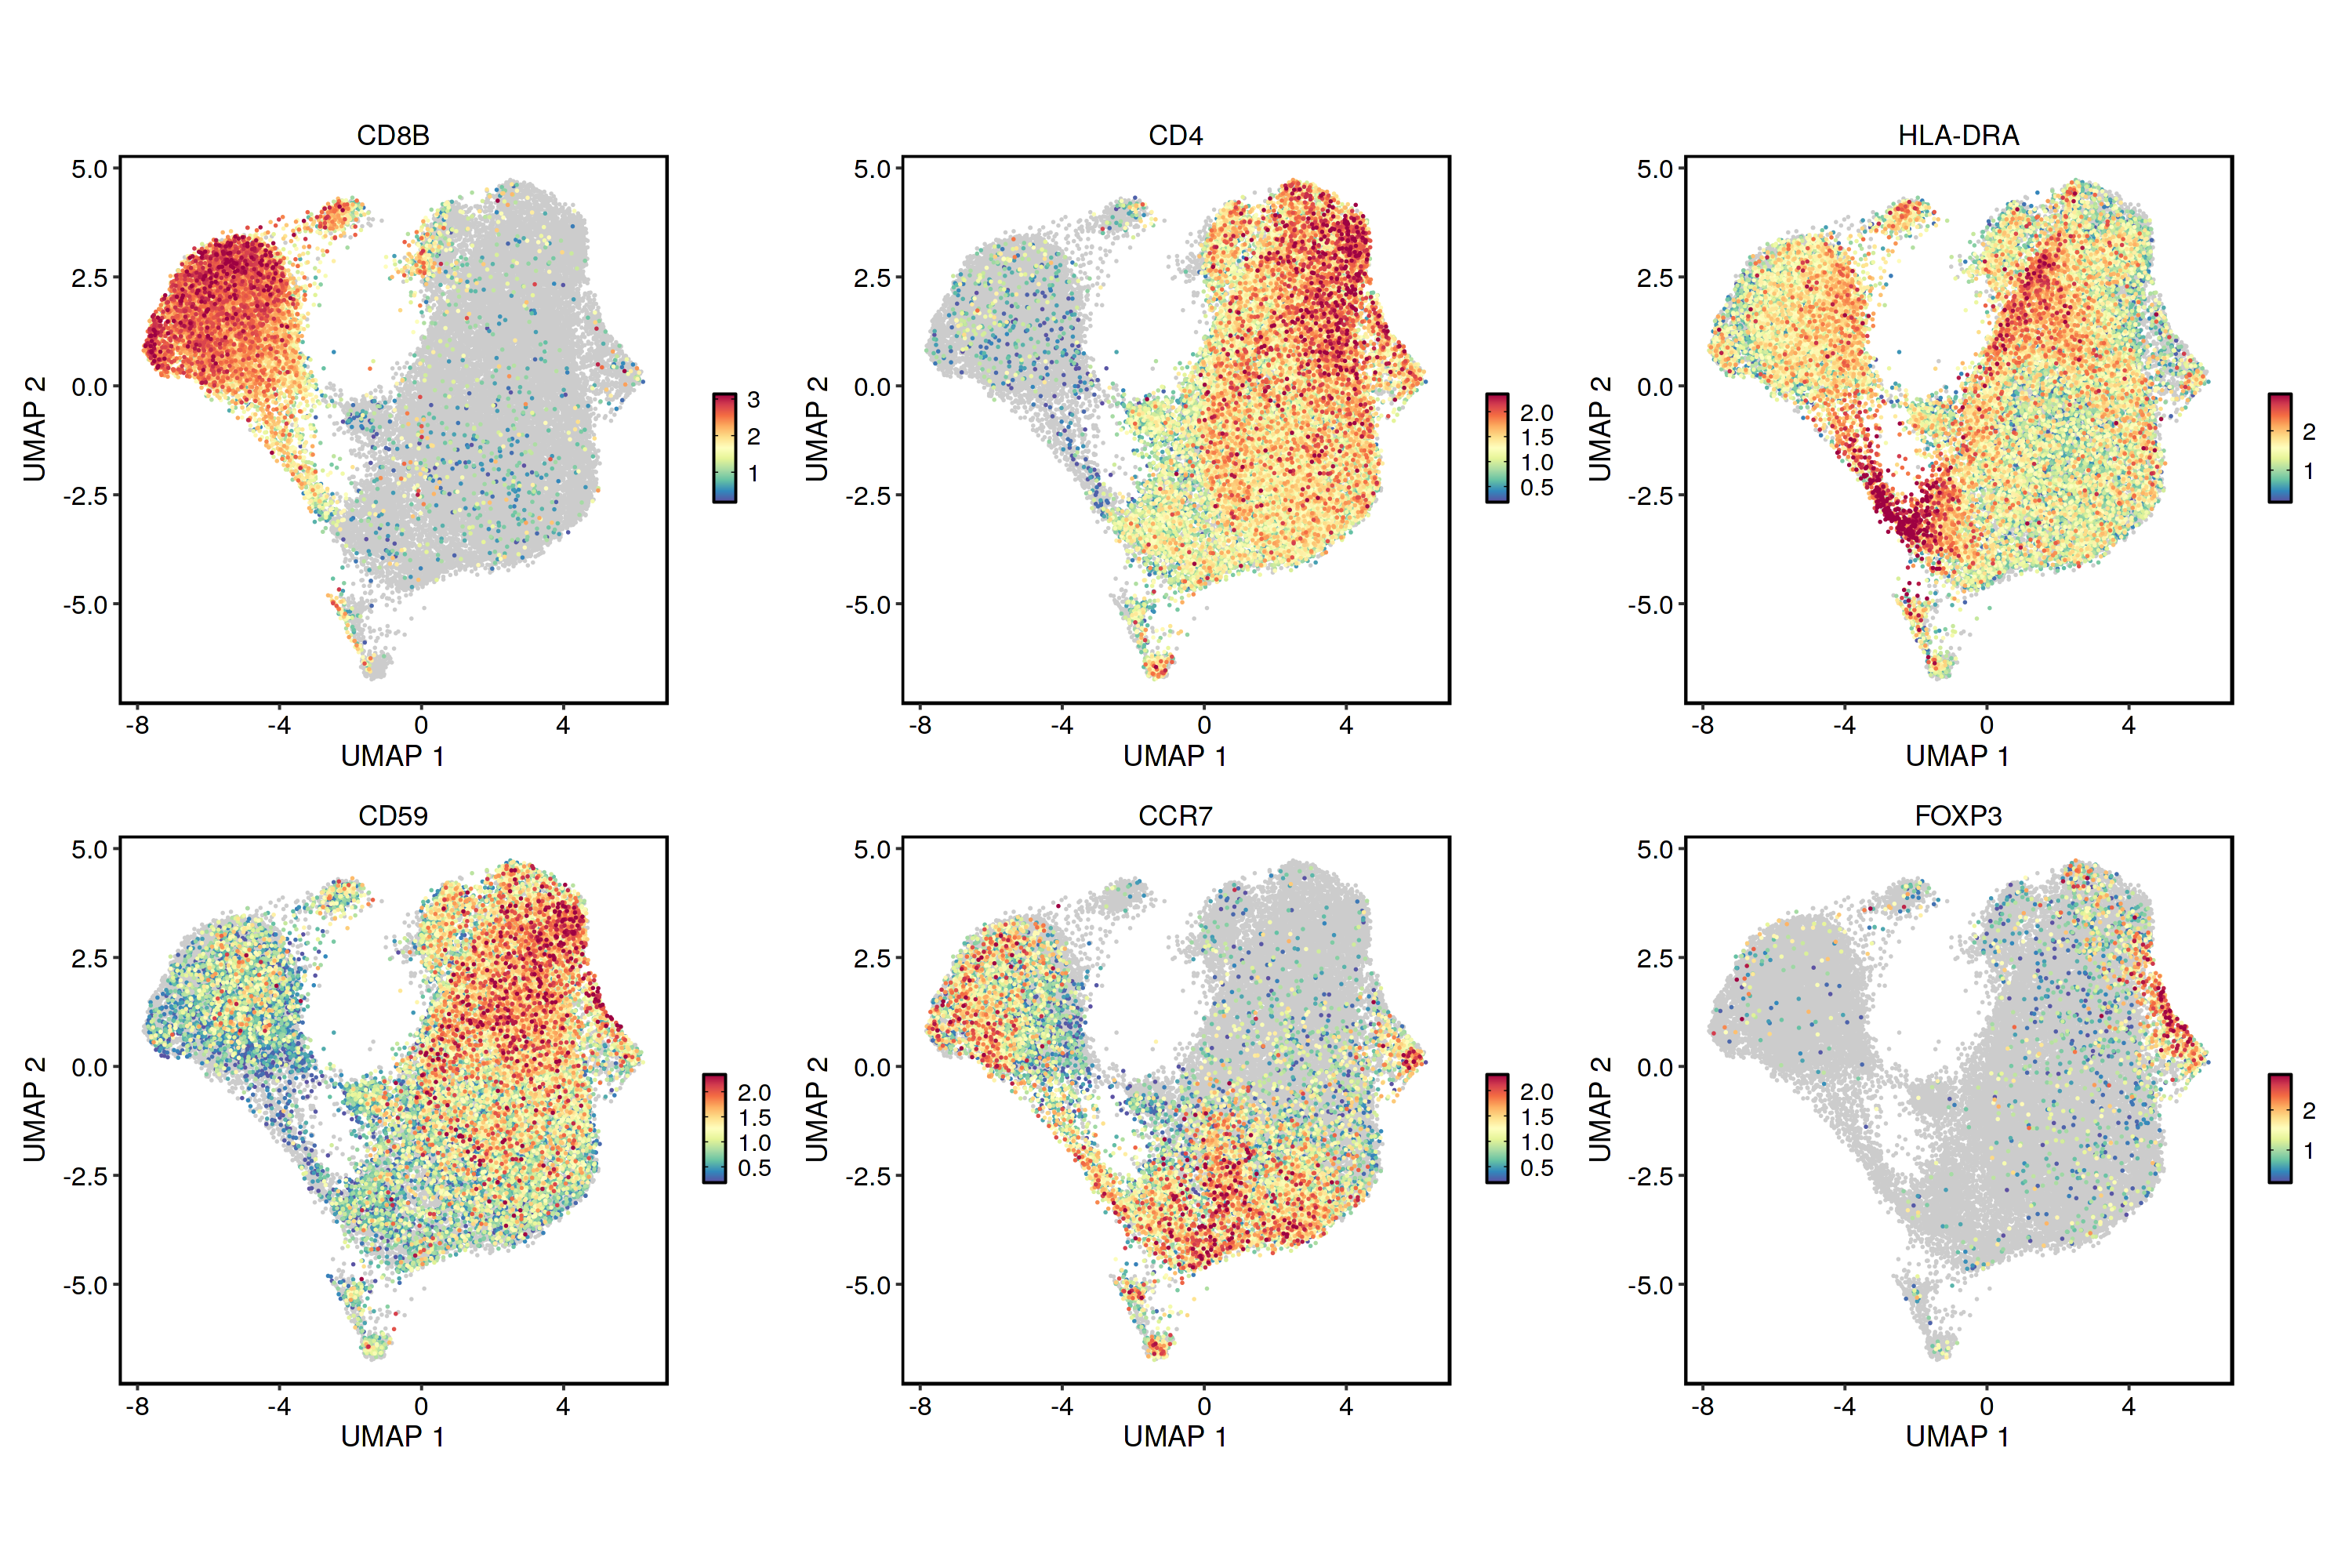

In [130]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res=200)
FeatureDimPlot(prepost, features = c('CD8B','CD4','HLA-DRA', 'CD59', 'CCR7','FOXP3'),  ncol=3,reduction = "umap.harmony", show_stat=F, 
               label = F, pt.size=0.001) & xlab('UMAP 1') & ylab('UMAP 2')

In [ ]:
5 - TH17
6 - TH2

In [133]:
Idents(prepost) <- prepost$harmony_clusters
prepost <- RenameIdents(prepost, 
       "0" = "0. CD8+ T",
       "1" = "1. CD4+ T",
       "2" = "2. CD4+ T", # central CCR7
       "3" = "3. CD4+ T", # central CCR7
       "4" = "4. CD4+ T", # central CCR7
       "5" = "5. Th17",
       "6" = "6. Th2", 
       "7" = "7. Treg",
       "8" = "8. CD4+ T",
       "9" = "9. CD4+ T", # cycling
       "10" = "10. CD8+ T",
       "11" = "11. CD8+ T" 
)
prepost$cell_type_clust <- Idents(prepost)

In [134]:
prepost$cell_type <- sub("^\\d+\\.\\s*", "", prepost$cell_type_clust)

In [1]:
prepost <- readRDS("../ProcessedData/seurat/clustered_ip4.rds")

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


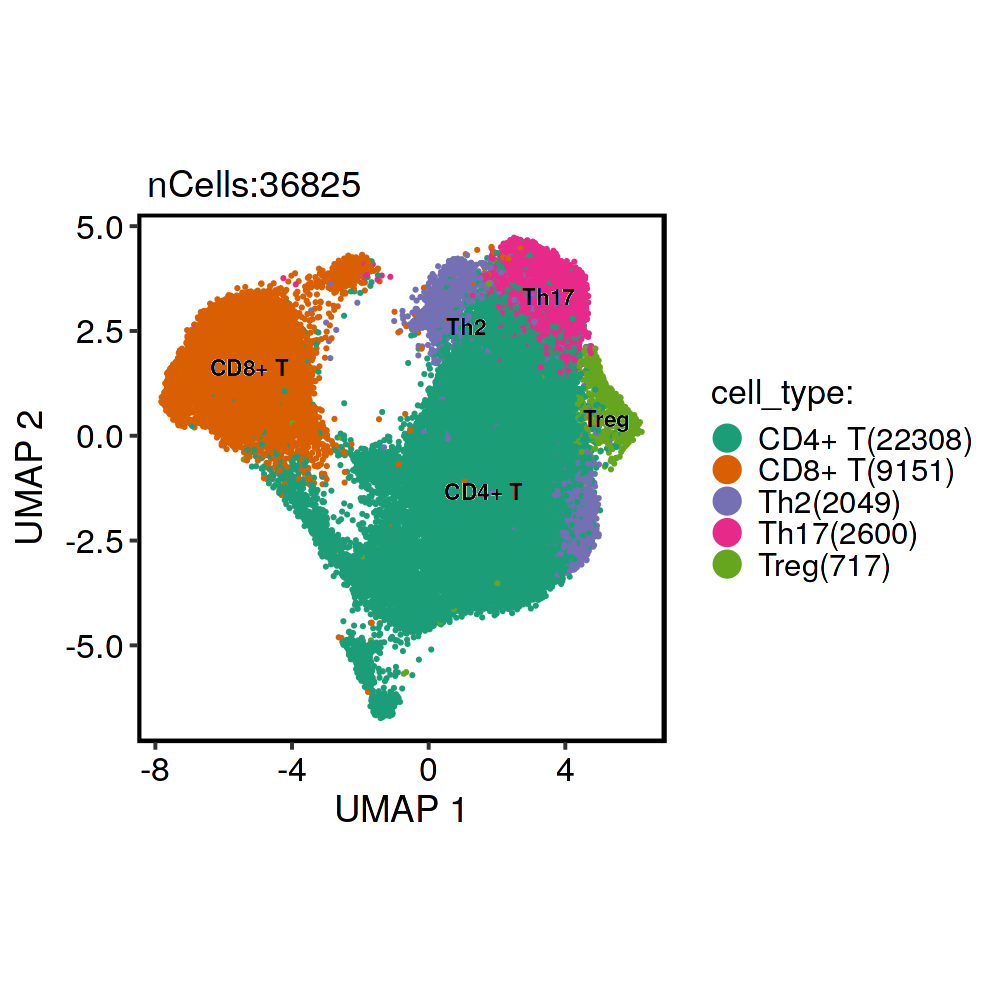

In [4]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=200)
CellDimPlot(srt = prepost, group.by = c( "cell_type"), palette='Dark2',
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')


In [5]:
panel.path = 'Final/Figures/'

In [12]:
pdf(file.path(panel.path, paste0("IP_celltypes.pdf")), width=5, height=5)
CellDimPlot(srt = prepost, group.by = c( "cell_type"), palette='Dark2',
    label=T, label_insitu=T, label.fg = "black", label.bg = "white", label.bg.r = 0,label.size =2.8, label_repel = F, pt.size=0.1,
    ncol=1, reduction = "umap.harmony") & xlab('UMAP 1')  & ylab('UMAP 2')

dev.off()

Warning message:
"No shared levels found between `names(values)` of the manual scale and the
data's fill values."


pdf 
  2

In [11]:
Idents(prepost) <- 'cell_type'

In [26]:
genes <- c(
    
    "CD40LG","CD4", "IL7R","TCF7", "CD8B","CD8A","CTSW",
    'PTGDR2', "IRX3","IL9R","IL17RB",
    'RORC','CCR6','KLRB1','IL26',
    
    "FOXP3", "IKZF2","IL2RA"
) 

In [23]:
de.markers <- FindMarkers(prepost, ident.1 = "CD4+ T", ident.2 = "Treg", only.pos = TRUE)
de.markers$diff =  de.markers$pct.1 -  de.markers$pct.2
head(de.markers %>% arrange(-diff), 20)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,diff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL7R,4.927394e-189,2.6102231,0.794,0.215,1.803525e-184,0.579
LINC01871,1.357209e-108,1.9660274,0.663,0.218,4.967657e-104,0.445
ANXA1,4.368703e-91,1.2320661,0.739,0.301,1.599033e-86,0.438
GZMA,3.702788e-98,2.6209352,0.603,0.197,1.355294e-93,0.406
LRRN3,3.148364e-79,1.8305664,0.575,0.194,1.152364e-74,0.381
ID2,2.525150e-93,1.5303855,0.770,0.410,9.242556e-89,0.360
ITGA4,2.416471e-87,1.9075471,0.659,0.300,8.844768e-83,0.359
NUCB2,2.868559e-82,1.9037797,0.617,0.264,1.049950e-77,0.353
STMN1,3.283092e-61,1.6231319,0.508,0.179,1.201677e-56,0.329


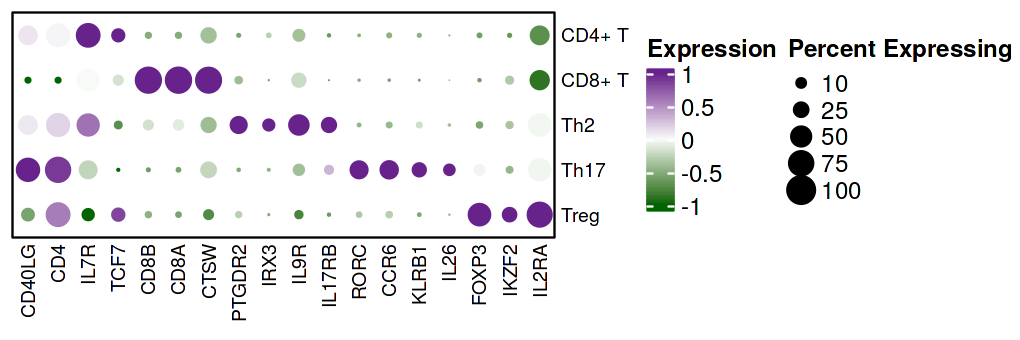

In [27]:
options(repr.plot.width = 6, repr.plot.height = 2, repr.plot.res=170)
P <- Clustered_DotPlot(prepost,  features = genes, k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = F, flip=T, exp_color_max=1, exp_color_min=-1,  
        show_ident_colors=F,  colors_use_exp = colorRampPalette(c("darkgreen","white","darkorchid4"))(50)) 

In [13]:
pdf(file.path(panel.path, paste0("IP_celltype_markers.pdf")), width=6, height=2)
P <- Clustered_DotPlot(prepost,  features = genes, k = 1, x_lab_rotate=90,
        cluster_feature = F, cluster_ident = F, flip=T, exp_color_max=1, exp_color_min=-1,  
        show_ident_colors=F,  colors_use_exp = colorRampPalette(c("darkgreen","white","darkorchid4"))(50)) 
dev.off()

pdf 
  2

In [137]:
saveRDS(prepost, "../ProcessedData/seurat/clustered_ip4.rds")